# PySpark program NYC taxi data

Inizialitazion of spark: 

In [1]:
import time
import matplotlib.pyplot as plt
import pandas as pd
start = time.time()
import findspark
findspark.init("/home/allsd/Downloads/spark-3.0.0-preview2-bin-hadoop2.7")
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("prueba").master("local[*]").getOrCreate()

Import the datasets

In [2]:
df = spark.read.csv("tripdata_2017-01.csv",
                   header='true', 
                   inferSchema='true')

df2 = spark.read.csv("tripdata_2017-02.csv",
                   header='true', 
                   inferSchema='true')

zones = spark.read.csv("taxi+_zone_lookup.csv",
                   header='true', 
                   inferSchema='true')

df = df.union(df2)

Preprocessing of the data which consists in modifying the type of the column and generation of new columns by joining other tables:

In [3]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import hour, col, to_timestamp, unix_timestamp,when, explode

#Create new columns
df = df.withColumn('tpep_pickup_datetime', to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn('tpep_dropoff_datetime', to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("hour_pickup",hour(col("tpep_pickup_datetime")))

#Filter total_amount and trip_distance
df = df.filter(df.total_amount > 0)
df = df.filter(df.trip_distance > 0)

#Join zones 
df = df.join(zones, (zones.LocationID == df.PULocationID), how = "left")
columns_to_drop = ['LocationID','Zone', 'service_zone']
df = df.drop(*columns_to_drop)
df = df.withColumnRenamed("Borough","PUBorough")
df = df.join(zones, (zones.LocationID == df.DOLocationID), how = "left")
columns_to_drop = ['LocationID','Zone', 'service_zone']
df = df.drop(*columns_to_drop)
df = df.withColumnRenamed("Borough","DOBorough")

df = df.withColumn('Short_Long',when(df.trip_distance >= 20,"Long").otherwise('Short'))
prep_end = time.time()

Get the average speed for each one of the trips

In [4]:
#Calculate avg_speed for each row
avg_speed_start = time.time()
timeDiff = (unix_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss") - unix_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("trip_time", timeDiff/3600)
df = df.withColumn("avg_speed", col("trip_distance")/col("trip_time"))
df = df.filter(df.avg_speed > 0)
df = df.filter(df.avg_speed < 150)

Get the average speed per hour taking as reference the pickup time.

In [5]:
#rdd = df.rdd.map(lambda x : [x.hour_pickup, x.avg_speed])
#rdd.getNumPartitions()

avg_by_key = df.rdd.map(lambda x : [x.hour_pickup, x.avg_speed]) \
    .mapValues(lambda v: (v, 1)) \
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
    .mapValues(lambda v: v[0]/v[1])

#avg_by_key.take(24)
avg_speed_end = time.time()

Number of trips per trajectory  and average percentage of tips over the fare amount in terms of Borough locations

In [6]:
zone_start = time.time()
#Number of trips by Borough and percentage of tip based on the fare_amount
trips = df.rdd.map(lambda x: [(x.PUBorough, x.DOBorough),(x.tip_amount, x.fare_amount, 1)])\
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2]))\
    .mapValues(lambda v: (v[0]/v[1],v[2]))

#trips.take(4)
zone_end = time.time()

Indicators by type of journey based on distance

In [7]:
distances_start = time.time()
distance = df.rdd.map(lambda x: [x.Short_Long,(x.passenger_count, x.payment_type, x.trip_distance, x.fare_amount, x.tip_amount, x.tolls_amount, x.total_amount, x.avg_speed, 1)])\
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2], a[3]+b[3], a[4]+b[4],a[5]+b[5], a[6]+b[6], a[7]+b[7], a[8]+b[8]))\
    .mapValues(lambda v: (v[0]/v[8],v[1]/v[8], v[2]/v[8], v[3]/v[8],v[4]/v[8],v[5]/v[8],v[6]/v[8], v[7]/v[8]))
#distance.take(4)
distances_end = time.time()

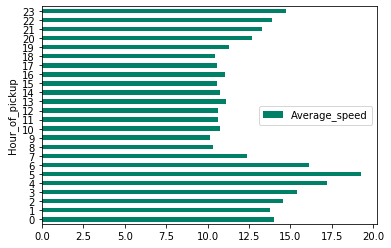

/home/allsd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()
/home/allsd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  if sys.path[0] == '':


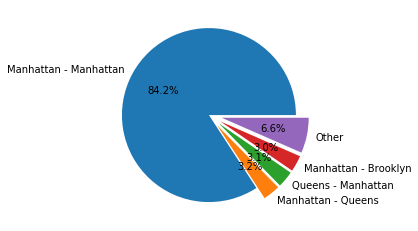

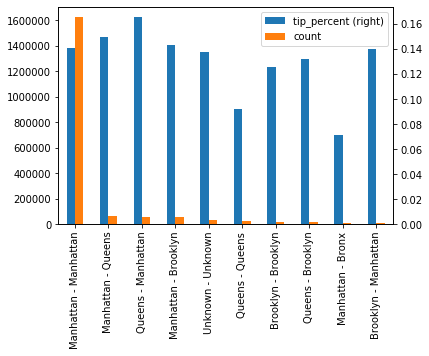

In [8]:
plot_start = time.time()

data = avg_by_key.toDF(["Hour_of_pickup", "Average_speed"]).toPandas() \
    .sort_values('Hour_of_pickup')

data.plot(kind='barh', x='Hour_of_pickup', y='Average_speed')
plt.show()

data = trips.toDF(["key", "value"]).toPandas()

data['PUBorough'], data['DOBorough'] = data['key'].str
data['tip_percent'], data['count'] = data['value'].str

data = data.sort_values(by=['count'],ascending = False)

data['id'] = data.PUBorough + ' - ' + data.DOBorough

data1 = data.drop(columns = ['key','value','tip_percent'])
tripsg = data1.iloc[0:4]

row = pd.DataFrame([['Other', 'Other', data['count'].sum() - tripsg['count'].sum(), 'Other']], 
                  columns = ["DOBorough", "PUBorough", "count", "id"])
tripsg = tripsg.append(row)

data = data.iloc[0:10]

data.set_index('id')

plt.pie(tripsg['count'],
    labels=tripsg['id'],
    explode=(0, 0.15, 0.15, 0.15, 0.15),
    autopct='%1.1f%%',
    )
plt.show()

fig = data.plot( kind= 'bar' , secondary_y= 'tip_percent' , rot= 90 )
fig.set_xticklabels(data.id)

plot_end = time.time()
spark.stop()
end = time.time()

In [9]:
print("Preprocessing time in pyspark: " + str(prep_end - start) + " seconds")
print("Average speed calculation in pyspark: " + str(avg_speed_end - avg_speed_start) + " seconds")
print("Number of trips by zone of travel and average of tips in pyspark: " + str(zone_end - zone_start)+ " seconds")
print("Calculation of mean by type of travel in pyspark: " + str(distances_end -distances_start)+  " seconds")
print("Plot time in pyspark (includes df transformation): " + str(plot_end - plot_start)+ " seconds")
print("Total time in pyspark: " + str(end - start)+ " seconds")

Preprocessing time in pyspark: 12.9056715965271 seconds
Average speed calculation in pyspark: 0.9677262306213379 seconds
Number of trips by zone of travel and average of tips in pyspark: 0.028355121612548828 seconds
Calculation of mean by type of travel in pyspark: 0.04410552978515625 seconds
Plot time in pyspark (includes df transformation): 39.867870807647705 seconds
Total time in pyspark: 54.58760356903076 seconds
